<a href="https://colab.research.google.com/github/ikdmtm/LSTM_N225/blob/master/lstm01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
# lstmで日経平均の予測

In [77]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
%cd /content/drive/MyDrive/kaggle/RNN

/content/drive/MyDrive/kaggle/RNN


In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [80]:
# データの読み込み
train = pd.read_csv("data/N225_2.csv")

In [81]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-01-07,6552.649902,6552.649902,6552.649902,6552.649902,6552.649902,0.0
1,1980-01-08,6563.279785,6563.279785,6563.279785,6563.279785,6563.279785,0.0
2,1980-01-09,6591.830078,6591.830078,6591.830078,6591.830078,6591.830078,0.0
3,1980-01-10,6594.009766,6594.009766,6594.009766,6594.009766,6594.009766,0.0
4,1980-01-11,6615.509766,6615.509766,6615.509766,6615.509766,6615.509766,0.0


In [82]:
train.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10709 entries, 0 to 10708
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10709 non-null  object 
 1   Open       10314 non-null  float64
 2   High       10314 non-null  float64
 3   Low        10314 non-null  float64
 4   Close      10314 non-null  float64
 5   Adj Close  10314 non-null  float64
 6   Volume     10314 non-null  float64
dtypes: float64(6), object(1)
memory usage: 585.8+ KB


<Figure size 432x288 with 0 Axes>

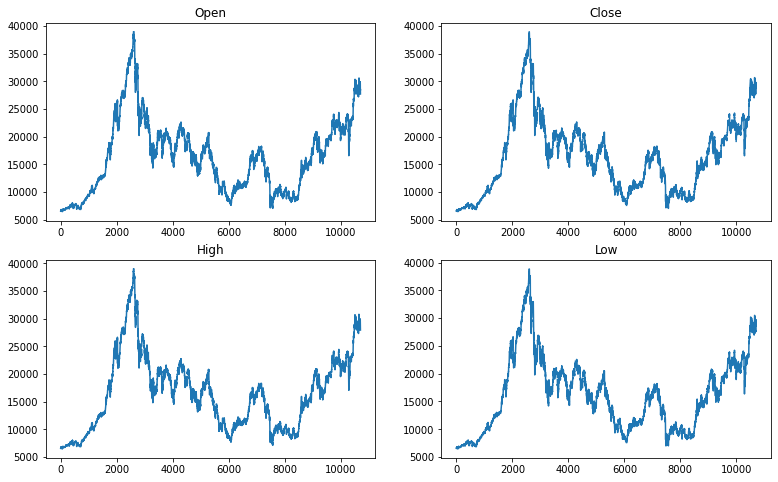

In [84]:
# データをプロット
from matplotlib import pyplot as plt
from random import randint

x = list(range(len(train)))
y1 = train['Open']
y2 = train['Close']
y3 = train['High']
y4 = train['Low']

fig = plt.figure()
fig=plt.figure(figsize=(13,8))

ax = fig.add_subplot(2, 2, 1)
ax.plot(x, y1)
ax.set_title('Open')

ax = fig.add_subplot(2, 2, 2)
ax.plot(x, y2)
ax.set_title('Close')

ax = fig.add_subplot(2, 2, 3)
ax.plot(x, y3)
ax.set_title('High')

ax = fig.add_subplot(2, 2, 4)
ax.plot(x, y4)
ax.set_title('Low')

plt.show()

In [85]:
train.isnull().sum()

Date           0
Open         395
High         395
Low          395
Close        395
Adj Close    395
Volume       395
dtype: int64

In [86]:
# nullが含まれる列を削除
train = train.dropna(how='any')
train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [87]:
len(train)

10314

In [108]:
# 標準化

train1 = train[['Close']]
train2 = train[['Open', 'High', 'Low', 'Close']] 

from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler1.fit(train1)
train_scaled1 = scaler1.transform(train1)
print(train_scaled1)
print(len(train_scaled1))


from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
scaler2.fit(train2)
train_scaled2 = scaler2.transform(train2)
print(train_scaled2[0:5])
print(len(train_scaled2))

[[-1.48806888]
 [-1.48646537]
 [-1.48215856]
 ...
 [ 1.72037198]
 [ 1.73754764]
 [ 1.71756623]]
10314
[[-1.48840135 -1.49470842 -1.48172636 -1.48806888]
 [-1.4867982  -1.49311341 -1.48011395 -1.48646537]
 [-1.48249239 -1.48882943 -1.47578326 -1.48215856]
 [-1.48216366 -1.48850237 -1.47545263 -1.48182976]
 [-1.47892113 -1.4852763  -1.47219136 -1.47858649]]
10314


In [89]:
x1 = train_scaled1[0:10300].astype(np.float32) # 単変量
#x1 = train.iloc[0:10300, 3:4].values.astype(np.float32)
print(x1[0:5])
print(len(x1))

[[-1.4880689]
 [-1.4864653]
 [-1.4821585]
 [-1.4818298]
 [-1.4785864]]
10300


In [90]:
x2 = train_scaled2[0:10300, 0:4].astype(np.float32) # 多変量
#x2 = train.iloc[0:10300, 1:5].values.astype(np.float32)
print(x2[0:5])
print(len(x2))

[[-1.4884013 -1.4947084 -1.4817264 -1.4880689]
 [-1.4867982 -1.4931134 -1.480114  -1.4864653]
 [-1.4824923 -1.4888295 -1.4757832 -1.4821585]
 [-1.4821637 -1.4885024 -1.4754527 -1.4818298]
 [-1.4789212 -1.4852763 -1.4721913 -1.4785864]]
10300


In [91]:
y = train_scaled1[51:10301].astype(np.float32) #予測するデータ
#y = train.iloc[51:10301, 4:5].values.astype(np.float32)
print(y[0:5])
print(len(y))

[[-1.4832251]
 [-1.4851847]
 [-1.4858664]
 [-1.4912956]
 [-1.4905987]]
10250


In [92]:
# ５０行１セットで訓練データを作成
length = 50
x1_data = [] # 単変量lstm用の入力
x2_data = [] # 多変量lstm用の入力
y_data = [] #予測したいデータ

for i in range(len(x1)-length):
    x1_data.append(x1[i:i+50])
    x2_data.append(x2[i:i+50])

x1_train = np.asarray(x1_data)
x2_train = np.asarray(x2_data)

x1_train = np.reshape(x1_train,(x1_train.shape[0],x1_train.shape[1],1))
x2_train = np.reshape(x2_data,(x2_train.shape[0],x1_train.shape[1],4,1))
y_train = y.reshape(y.shape[0], 1)

print(x1_train.shape)
print(x2_train.shape)
print(y_train.shape)

(10250, 50, 1)
(10250, 50, 4, 1)
(10250, 1)


In [107]:
y_train[0:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.4832251],
       [-1.4851847],
       [-1.4858664],
       [-1.4912956],
       [-1.4905987]], dtype=float32)>

In [94]:
x1_train = tf.convert_to_tensor(x1_train)
x2_train = tf.convert_to_tensor(x2_train)
y_train = tf.convert_to_tensor(y_train)

In [95]:
'''
# 標準化
from sklearn.preprocessing import StandardScaler
k = 0
x1_scaled = {}
x2_scaled = {}

scaler1 = StandardScaler()
scaler1.fit(x1_train[0])

scaler2 = StandardScaler()
#scaler2.fit(x2_train[0][0])

for k in range(10250):
  x1_scaled[k] = scaler1.transform(x1_train[k])
  #x2_scaled[k] = scaler2.transform(x2_train[k])
#scaler.fit(y)
#y_scaled = scaler.transform(y)
print(x1_scaled[0])
#print(x2_scaled[0])
#x2_scaled = x2_scaled.values.reshape(50, 4, 1)
'''

'\n# 標準化\nfrom sklearn.preprocessing import StandardScaler\nk = 0\nx1_scaled = {}\nx2_scaled = {}\n\nscaler1 = StandardScaler()\nscaler1.fit(x1_train[0])\n\nscaler2 = StandardScaler()\n#scaler2.fit(x2_train[0][0])\n\nfor k in range(10250):\n  x1_scaled[k] = scaler1.transform(x1_train[k])\n  #x2_scaled[k] = scaler2.transform(x2_train[k])\n#scaler.fit(y)\n#y_scaled = scaler.transform(y)\nprint(x1_scaled[0])\n#print(x2_scaled[0])\n#x2_scaled = x2_scaled.values.reshape(50, 4, 1)\n'

In [96]:
# 単変量lstm　日経平均の１日のCloseの値を予測するモデル
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation  

data_dim = 1
length_of_sequences = 50
batch_size = 10250
h_num = 50
in_out_neurons = 1

model = Sequential()  
model.add(LSTM(h_num, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False))  
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="adam") #  optimizer="rmsprop"
model.fit(x1_train, y_train, batch_size=100, epochs=30) 

Epoch 1/30
103/103 [==============================] - 4s 26ms/step - loss: 0.1084
Epoch 2/30
103/103 [==============================] - 3s 25ms/step - loss: 0.0059
Epoch 3/30
103/103 [==============================] - 3s 24ms/step - loss: 0.0054
Epoch 4/30
103/103 [==============================] - 3s 25ms/step - loss: 0.0050
Epoch 5/30
103/103 [==============================] - 2s 24ms/step - loss: 0.0048
Epoch 6/30
103/103 [==============================] - 2s 24ms/step - loss: 0.0047
Epoch 7/30
103/103 [==============================] - 2s 24ms/step - loss: 0.0044
Epoch 8/30
103/103 [==============================] - 3s 25ms/step - loss: 0.0042
Epoch 9/30
103/103 [==============================] - 2s 24ms/step - loss: 0.0041
Epoch 10/30
103/103 [==============================] - 3s 24ms/step - loss: 0.0040
Epoch 11/30
103/103 [==============================] - 3s 24ms/step - loss: 0.0037
Epoch 12/30
103/103 [==============================] - 3s 24ms/step - loss: 0.0036
Epoch 13/30
1

In [106]:
y_submit = [] 
y_submit = model.predict(x1_train, batch_size=50, verbose=1, steps=205)
print(y_submit.shape)
print(y_submit[0:5])
#y_submit.to_csv('submission/submit01.csv')

205/205 [==============================] - 1s 7ms/step
(10250, 1)
[[-1.4674915]
 [-1.4670657]
 [-1.4668996]
 [-1.4677887]
 [-1.4685409]]


In [105]:
# 標準化を戻す
y_submit = scaler1.inverse_transform(y_submit)
y_submit[0:5]

array([[44358930.],
       [44377644.],
       [44384940.],
       [44345870.],
       [44312816.]], dtype=float32)

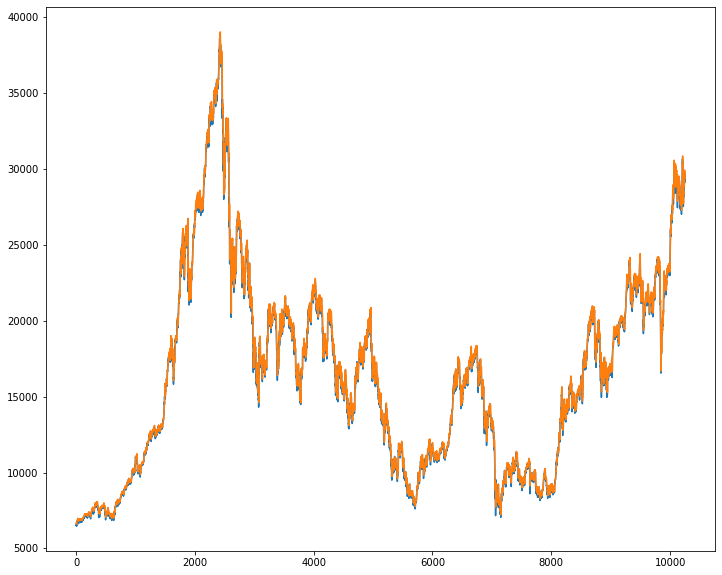

In [100]:
# 青が元データ、オレンジが予測
x1 = list(range(len(train1.iloc[51:10301])))
x2 = list(range(len(y_submit)))
y1 = train1.iloc[51:10301]
y2 = y_submit

x3 = list(range(len(train1.iloc[10251:10301])))
x4 = list(range(len(y_submit[10200:10250])))
y3 = train1.iloc[10251:10301]
y4 = y_submit[10200:10250]

plt.figure(figsize=(12,10))

plt.plot(x1, y1)
plt.plot(x2, y2)
plt.show()

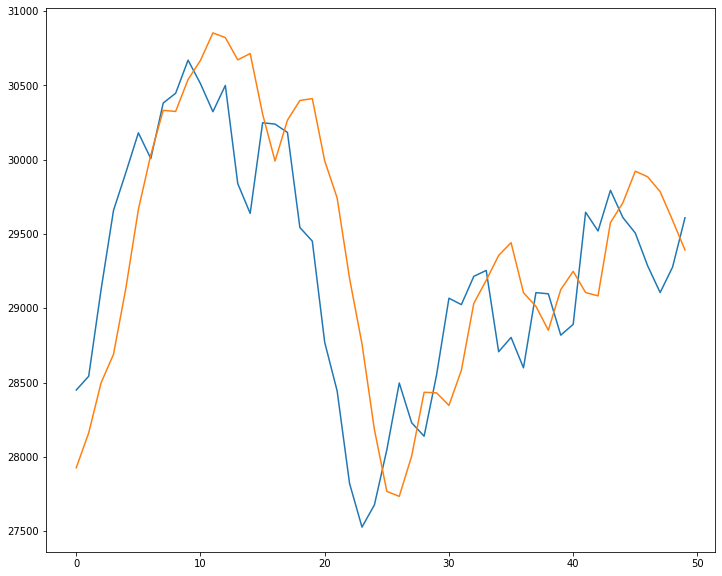

In [101]:
# 50個を拡大表示
x3 = list(range(len(train1.iloc[10251:10301])))
x4 = list(range(len(y_submit[10200:10250])))
y3 = train1.iloc[10251:10301]
y4 = y_submit[10200:10250]

plt.figure(figsize=(12,10))

plt.plot(x3, y3)
plt.plot(x4, y4)
plt.show()

In [102]:
'''
# 多変量lstmで予測
data_dim = 4
timesteps = 10700
#num_classes = 10
batch_size = 50

# 想定している入力バッチshape: (batch_size, timesteps, data_dim)
# 注意: ネットワークがstatefulであるため，batch_input_shapewをすべてうめて与えなければなりません
# バッチkのi番目のサンプルは，バッチk-1のi番目のサンプルの次の時系列となります．
model = Sequential()
model.add(LSTM(100, return_sequences=True, stateful=True, batch_input_shape=(batch_size, timesteps, data_dim)))
#model.add(LSTM(32, return_sequences=True, stateful=True))
#model.add(LSTM(32, stateful=True))
model.add(Dense(1, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x_scaled, y, batch_size=batch_size, epochs=10, shuffle=False)
'''

"\n# 多変量lstmで予測\ndata_dim = 4\ntimesteps = 10700\n#num_classes = 10\nbatch_size = 50\n\n# 想定している入力バッチshape: (batch_size, timesteps, data_dim)\n# 注意: ネットワークがstatefulであるため，batch_input_shapewをすべてうめて与えなければなりません\n# バッチkのi番目のサンプルは，バッチk-1のi番目のサンプルの次の時系列となります．\nmodel = Sequential()\nmodel.add(LSTM(100, return_sequences=True, stateful=True, batch_input_shape=(batch_size, timesteps, data_dim)))\n#model.add(LSTM(32, return_sequences=True, stateful=True))\n#model.add(LSTM(32, stateful=True))\nmodel.add(Dense(1, activation='softmax'))\n\nmodel.compile(loss='categorical_crossentropy',\n              optimizer='rmsprop',\n              metrics=['accuracy'])\n\nmodel.fit(x_scaled, y, batch_size=batch_size, epochs=10, shuffle=False)\n"